# Multi level loss 

When upsampling in the network can we add additional loss to improve the training .

Or can we use the different internal representation for future improvements 


Can we use the pixelated representation with temporal fusion for objet prediction 


# Code Hide

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/home/deebuls/Documents/phd/blender-dataset/MultiViewEvidentialUncertaintyFusion')
import robocup_model
import vkitti_model
import metrics
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import DeviceStatsMonitor,LearningRateMonitor,TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import h5py

import matplotlib.pyplot as plt
import numpy as np

import pytorch_lightning as pl

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import ConfusionMatrixDisplay
import segmentation_models_pytorch as smp
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts,CosineAnnealingLR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from robocup_dataloader import RoboCupDataset
from robocup_dataloader import SequentialRobocupDataset
import vkitti_dataloader
import epipolar_geometry
import evidence_loss
import uncertain_fusion
import plot_prediction

from metrics import IoU, SegmentationMetric
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip, RandomHorizontalFlip, RandomMotionBlur
from kornia.augmentation import RandomGaussianNoise, RandomSharpness, RandomCrop
from kornia.augmentation import RandomEqualize, RandomGaussianBlur


In [58]:
root = '../../learning_blenerproc/images_robocup'
# init train, val, test sets
train_dataset = RoboCupDataset(root, "train")
valid_dataset = RoboCupDataset(root, "valid")

# It is a good practice to check datasets don`t intersects with each other
#assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")

n_cpu = os.cpu_count()
n_batch_size = 32
print (" CPU ", n_cpu)
train_dataloader = DataLoader(train_dataset, batch_size=n_batch_size, shuffle=True, num_workers=int(n_cpu/2))
valid_dataloader = DataLoader(valid_dataset, batch_size=n_batch_size, shuffle=False, num_workers=int(n_cpu/2))


Loaded image for train :  534
Loaded image for valid :  534
Train size: 534
Valid size: 534
 CPU  16


In [60]:
batch = next(iter(valid_dataloader))
print (batch['image'].shape)

torch.Size([32, 3, 512, 512])


In [61]:
ARCH_NAME = 'FPN' 
OUT_CLASSES = 6
MODEL_PATH = './robocup_mobilenet.pt'
#MODEL_PATH = './robocup_resnet18.pt'
#MODEL_PATH = './robocup_efficientnet.pt'

ENCODER_NAME = 'timm-mobilenetv3_small_minimal_100'
#ENCODER_NAME = 'resnet18'
#ENCODER_NAME = 'efficientnet-b1'

TRAIN_DATASET_PATH = '/home/deebuls/Documents/phd/blender-dataset/learning_blenerproc/images_robocup/'
VAL_DATASET_PATH = '/home/deebuls/Documents/phd/blender-dataset/learning_blenerproc/images_pose_robocup/'

In [62]:
model = torch.load(MODEL_PATH)

In [72]:
model.decoder

FPNDecoder(
  (p5): Conv2d(576, 256, kernel_size=(1, 1), stride=(1, 1))
  (p4): FPNBlock(
    (skip_conv): Conv2d(48, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (p3): FPNBlock(
    (skip_conv): Conv2d(24, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (p2): FPNBlock(
    (skip_conv): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (seg_blocks): ModuleList(
    (0): SegmentationBlock(
      (block): Sequential(
        (0): Conv3x3GNReLU(
          (block): Sequential(
            (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): GroupNorm(32, 128, eps=1e-05, affine=True)
            (2): ReLU(inplace=True)
          )
        )
        (1): Conv3x3GNReLU(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): GroupNorm(32, 128, eps=1e-05, affine=True)
            (2): ReLU(inplace=True)
          )
        )
        (2): Conv3x3GNReLU(

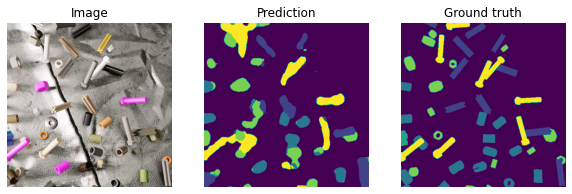

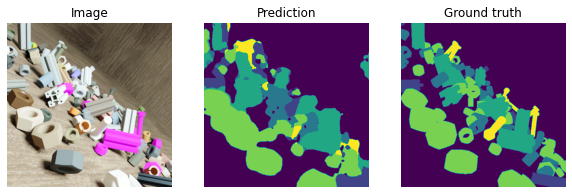

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/queues.py", line 241, in _feed
Exception ignored in:     <function _ConnectionBase.__del__ at 0x7f97b9a1a950>
Traceback (most recent call last):
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/connection.py", line 137, in __del__
close()
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/connection.py", line 182, in close
    close()
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/connection.py", line 182, in close
            self._close()
  File "/home/deebuls/miniconda3/envs/tpytorch/lib/python3.10/multiprocessing/connection.py", line 366, in _close
self._close()
  Fil

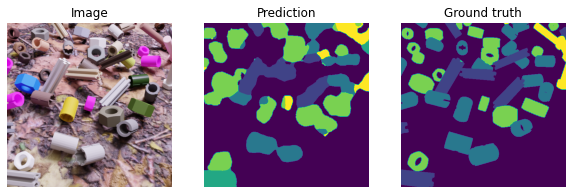

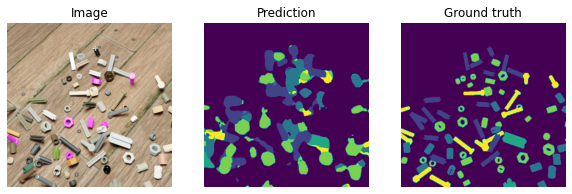

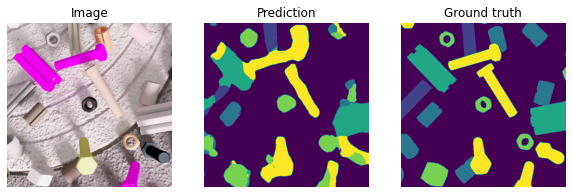

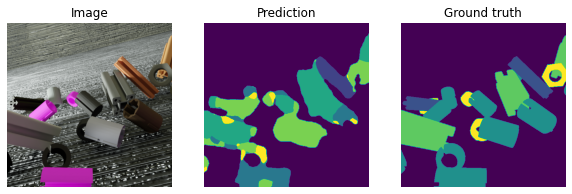

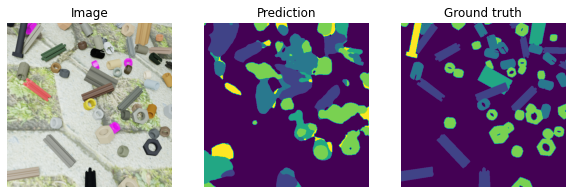

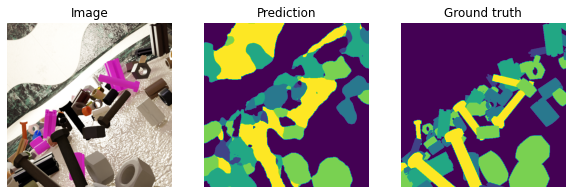

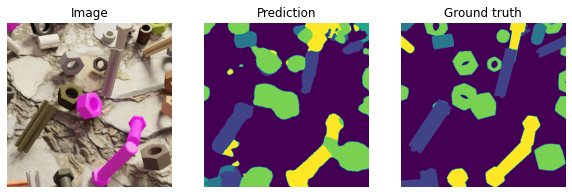

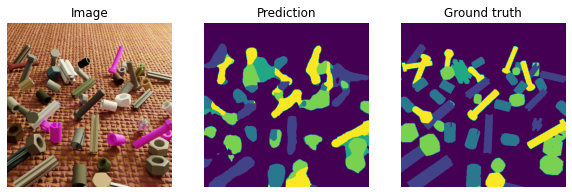

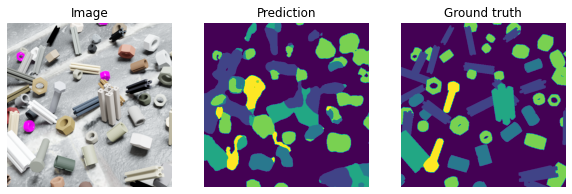

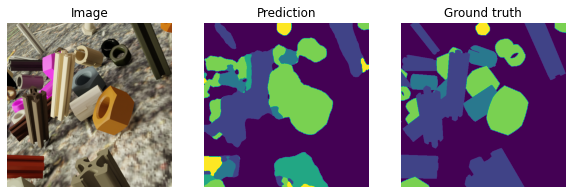

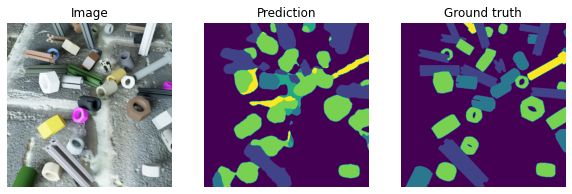

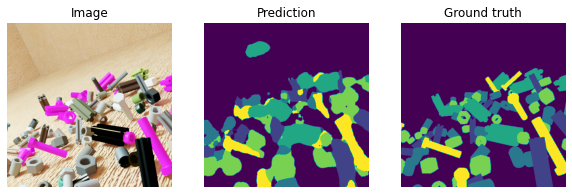

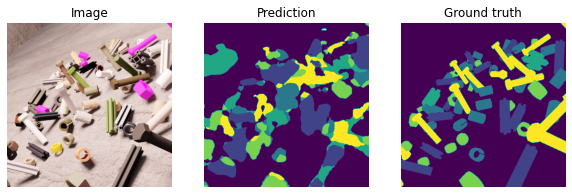

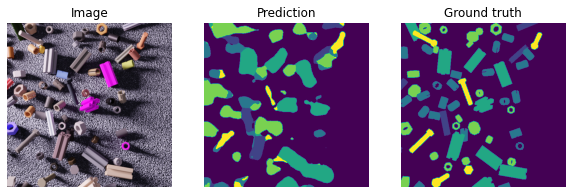

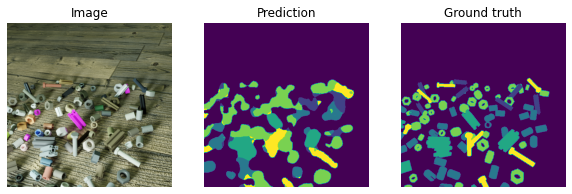

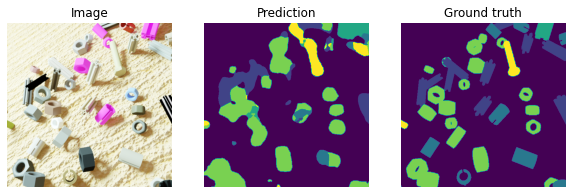

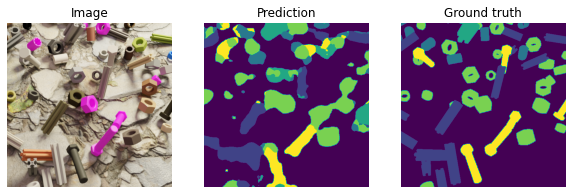

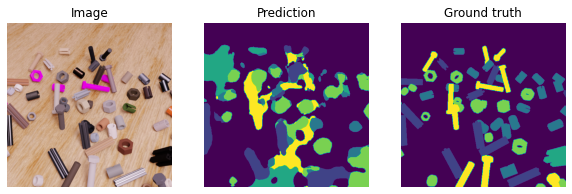

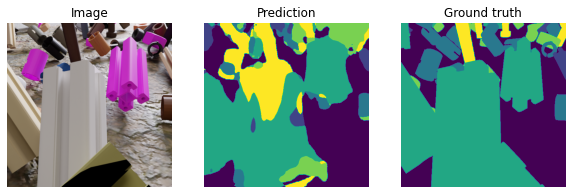

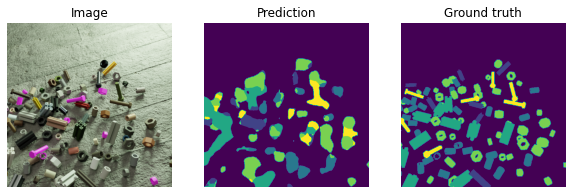

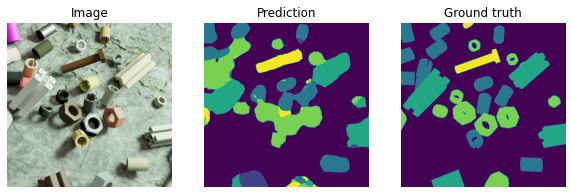

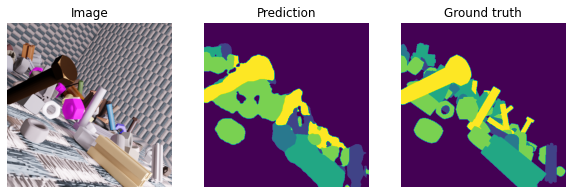

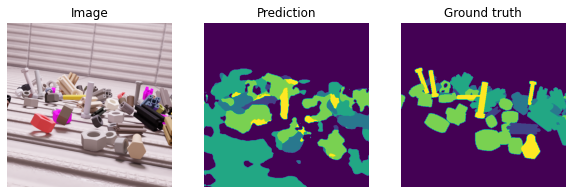

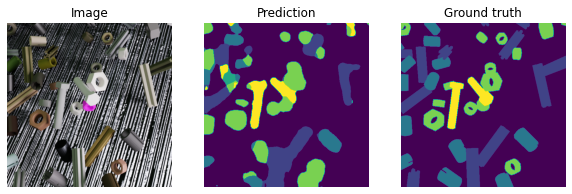

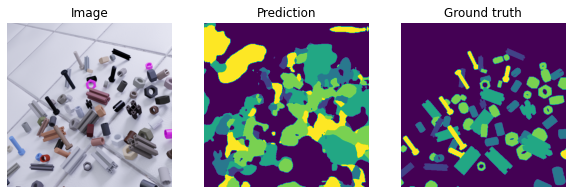

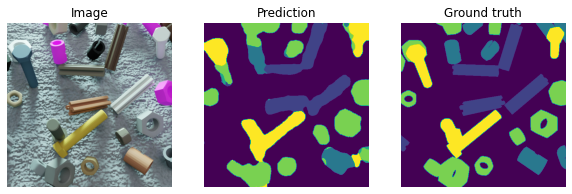

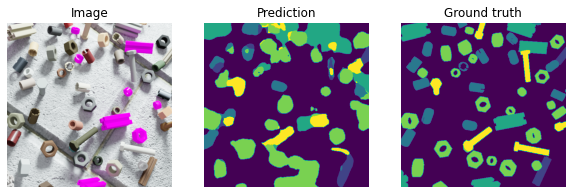

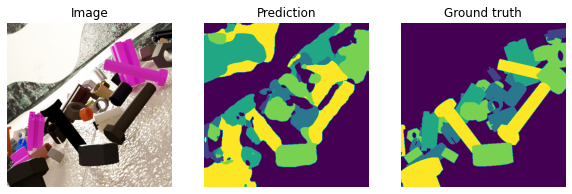

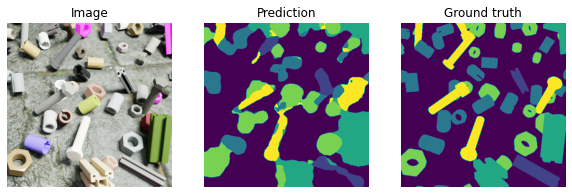

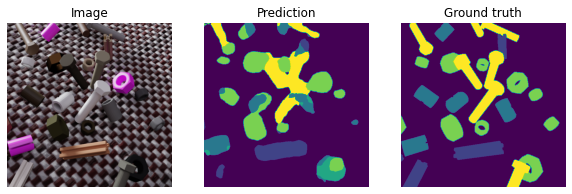

In [63]:
batch = next(iter(valid_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
#pr_masks = logits.sigmoid()
prob_mask = logits.log_softmax(dim=1).exp()
pred_mask = prob_mask.argmax(dim=1, keepdim=True)
for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")
    plt.savefig('result.png')
    plt.show()
    


# Unet

In [69]:
import torch.nn as nn 
import torchvision
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, 
                 enc_chs=(3,64,128,256,512,1024), 
                 dec_chs=(1024, 512, 256, 128, 64), 
                 num_class=1, 
                 retain_dim=False, 
                 out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out


In [70]:
unet = UNet()
x    = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])

In [74]:
unet.decoder

Decoder(
  (upconvs): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  )
  (dec_blocks): ModuleList(
    (0): Block(
      (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): Block(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    )
    (2): Block(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (3): Block(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu): ReLU()
      (conv2): Conv

In [3]:
import torch

In [25]:
480 / 32

15.0

In [26]:
x = torch.arange(1*3*480*480).reshape(1,3, 480, 480)
x

tensor([[[[     0,      1,      2,  ...,    477,    478,    479],
          [   480,    481,    482,  ...,    957,    958,    959],
          [   960,    961,    962,  ...,   1437,   1438,   1439],
          ...,
          [228960, 228961, 228962,  ..., 229437, 229438, 229439],
          [229440, 229441, 229442,  ..., 229917, 229918, 229919],
          [229920, 229921, 229922,  ..., 230397, 230398, 230399]],

         [[230400, 230401, 230402,  ..., 230877, 230878, 230879],
          [230880, 230881, 230882,  ..., 231357, 231358, 231359],
          [231360, 231361, 231362,  ..., 231837, 231838, 231839],
          ...,
          [459360, 459361, 459362,  ..., 459837, 459838, 459839],
          [459840, 459841, 459842,  ..., 460317, 460318, 460319],
          [460320, 460321, 460322,  ..., 460797, 460798, 460799]],

         [[460800, 460801, 460802,  ..., 461277, 461278, 461279],
          [461280, 461281, 461282,  ..., 461757, 461758, 461759],
          [461760, 461761, 461762,  ..., 4

In [27]:
xx = torch.tensor_split(x, int(480/3), dim=3)
print (x.shape)
for y in xx :
    print (y.shape)

torch.Size([1, 3, 480, 480])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])
torch.Size([1, 3, 480, 3])

In [28]:
xx

(tensor([[[[     0,      1,      2],
           [   480,    481,    482],
           [   960,    961,    962],
           ...,
           [228960, 228961, 228962],
           [229440, 229441, 229442],
           [229920, 229921, 229922]],
 
          [[230400, 230401, 230402],
           [230880, 230881, 230882],
           [231360, 231361, 231362],
           ...,
           [459360, 459361, 459362],
           [459840, 459841, 459842],
           [460320, 460321, 460322]],
 
          [[460800, 460801, 460802],
           [461280, 461281, 461282],
           [461760, 461761, 461762],
           ...,
           [689760, 689761, 689762],
           [690240, 690241, 690242],
           [690720, 690721, 690722]]]]),
 tensor([[[[     3,      4,      5],
           [   483,    484,    485],
           [   963,    964,    965],
           ...,
           [228963, 228964, 228965],
           [229443, 229444, 229445],
           [229923, 229924, 229925]],
 
          [[230403, 230404, 230405]

In [29]:
yy = torch.concat(torch.tensor_split( torch.concat(xx), 2, dim=2))
print (yy.shape)
yy = yy.permute(0,2,3,1)
print (yy.shape)
print (yy.reshape(-1, 27))

torch.Size([320, 3, 240, 3])
torch.Size([320, 240, 3, 3])
tensor([[     0, 230400, 460800,  ...,    962, 231362, 461762],
        [  1440, 231840, 462240,  ...,   2402, 232802, 463202],
        [  2880, 233280, 463680,  ...,   3842, 234242, 464642],
        ...,
        [226557, 456957, 687357,  ..., 227519, 457919, 688319],
        [227997, 458397, 688797,  ..., 228959, 459359, 689759],
        [229437, 459837, 690237,  ..., 230399, 460799, 691199]])


In [32]:
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [27]:
#[batch_size, n_classes, height, width] -> [1,3,6,6]
for xx in torch.tensor_split(x, 2, dim=3):
    print (xx.shape)
    for yy in torch.tensor_split(xx,2, dim=2 ):
        #[batch_size, n_classes, 3, 3]
        print (yy.shape)
        # [batch, 3, 3, n]
        yy = yy.permute(0,2,3,1)
        yy = yy.ravel()
        print (yy)

torch.Size([1, 3, 6, 3])
torch.Size([1, 3, 3, 3])
tensor([ 0, 36, 72,  1, 37, 73,  2, 38, 74,  6, 42, 78,  7, 43, 79,  8, 44, 80,
        12, 48, 84, 13, 49, 85, 14, 50, 86])
torch.Size([1, 3, 3, 3])
tensor([ 18,  54,  90,  19,  55,  91,  20,  56,  92,  24,  60,  96,  25,  61,
         97,  26,  62,  98,  30,  66, 102,  31,  67, 103,  32,  68, 104])
torch.Size([1, 3, 6, 3])
torch.Size([1, 3, 3, 3])
tensor([ 3, 39, 75,  4, 40, 76,  5, 41, 77,  9, 45, 81, 10, 46, 82, 11, 47, 83,
        15, 51, 87, 16, 52, 88, 17, 53, 89])
torch.Size([1, 3, 3, 3])
tensor([ 21,  57,  93,  22,  58,  94,  23,  59,  95,  27,  63,  99,  28,  64,
        100,  29,  65, 101,  33,  69, 105,  34,  70, 106,  35,  71, 107])
